In [62]:
# Simulate parity measurement of a 6-qubit stabilizer using a bare ancilla qubit.
# This is an attempt to replicate experimental results from a 15-ion trap in UMd.
# See relevant Mathematica data
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
import time
from numpy import *
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt

N = 7

# Define stabilizer measurement circuit
def stab_meas_circ(bit_str):
    circ = Circuit(N)

    for i in range(len(bit_str)):
        theta = pi/2 * (-1) ** (bit_str[i])
        circ.Y(i, theta)

    qubit_list = [0, 2, 1, 3, 5, 4]

    for i in range(len(qubit_list)):
        theta = pi/2 * (-1) ** i
        circ.XX(qubit_list[i], N - 1, theta)

    for i in range(N - 1):
        circ.Y(i, -pi/2)
        
    return circ


def stat_analysis(results):
    print(f"Number of data = {len(results)}")
    print(f"Average fidelity = {sum(results) / len(results)}")
    print(f"Max fidelity minus Min fidelity = {max(results) - min(results)}")
    print(f"Variance = {var(results)}")

def rep_fid_plot(runs, errors, err_arr=[0] * 6, rand_err=0, plot=True, analyze=True):
    results = []
    
    # Do circuit 64 times
    for i in range(2 ** (N - 1)):
        
        circ = stab_meas_circ(int_to_bit_str(i, N-1))
        circ.runs = runs
        
        ideal_state = circ.compute()[0]
        
        # Completely random time-dependent errors
        circ.errors = errors
        
        # Constant over-rotation errors
        for j in range(N - 1):
            circ.ideal_gates[j + N - 1][2] *= err_arr[j] + 1
                
        
        if rand_err != 0:
            err_arr = error_dist(N - 1)
            
            # Add error to each gate
            for j in range(N - 1):
#                 angle = [native_gate[2] * (xx_err * array(error_dist(runs)) + 1)]
                
                circ.ideal_gates[j + N - 1][2] *= rand_err * err_arr[j] + 1
        
        final_states = circ.compute()
        
#         fidelities = find_fidelities(final_states, ideal_state)
#         results.append(fidelities[0])

        # -- Getting the correct ancilla --
        measured_qubits = [6]
        
        sub_state = zero_state(1) * 0
        index = sum(int_to_bit_str(i, N-1)) % 2
        sub_state[index] = 1

        probs = find_prob(measured_qubits, sub_state, final_states)
        avg_prob = sum(probs) / runs
        results.append(avg_prob)
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.title(f"Probability of getting correct ancilla qubit VS input bit string")
        plt.plot(results)
    if analyze:
        stat_analysis(results)
    
    gate_angles = rand_err * err_arr
    return gate_angles, results

# --- Parallelize gates ---

def parallel_circ(runs, err, err_arr):
    # Initialize simple circuit
    circ = stab_meas_circ([0,0,0,0,0,0])

    circ.compute()
    
    # Create new circuit with custom gates
    circ.init_state = zero_state(N)
    circ.runs = 64 * runs

    # Edit noisy gates
    for i in range(0, 6):
        gate_angles = array([])
        for j in range(64):
            gate_angles = concatenate((gate_angles, (pi / 2) * (-1) ** int_to_bit_str(j, N-1)[i] * (1 + err[0] * error_dist(runs))))
        circ.noisy_gates[i][2][0] = gate_angles
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * runs))

    for i in range(6, 12):
        circ.noisy_gates[i][2][0] = - pi / 2 * (1 + err_arr[i - 6]) * (1 + err[2] * error_dist(64 * runs))
        circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * runs), 
                                    pi / 2 * err[1] * error_dist(64 * runs)]

    for i in range(12, 18):
        circ.noisy_gates[i][2][0] = - pi / 2 * (1 + err[0] * error_dist(64 * runs))
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * runs))

    return circ

def run_parallel_circ(runs, err, err_arr=[0] * 6):
#     start = time.time()
    
    ideal_states = parallel_circ(2, [0,0,0], [0] * 6).compute(compile_gates=False)
    final_states = parallel_circ(runs, err, err_arr).compute(compile_gates=False)

#     print(f"Time elapsed = {time.time() - start}")
    
    return final_states, ideal_states

def fid_dist(final_states, ideal_states, title='', plot=True, analyze=False):
    
    results = []
    for i in range(2 ** (N - 1)):
        # -- Getting the correct ancilla --
        measured_qubits = [6]
        
        sub_state = zero_state(1) * 0
        index = (1 + sum(int_to_bit_str(i, N-1))) % 2
        sub_state[index] = 1

        probs = find_prob(measured_qubits, sub_state, final_states[i * runs: (i + 1) * runs])
        avg_prob = sum(probs) / runs
        results.append(avg_prob)
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.title(f"Probability of getting correct ancilla qubit VS input bit string" if title=='' else title)
        plt.plot(results)
    if analyze:
        stat_analysis(results)
    
    return results
        


# Note: have to invert parity by one to get the right result, why?

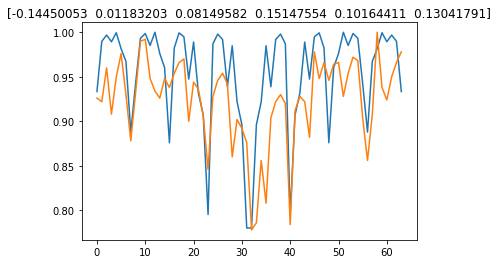

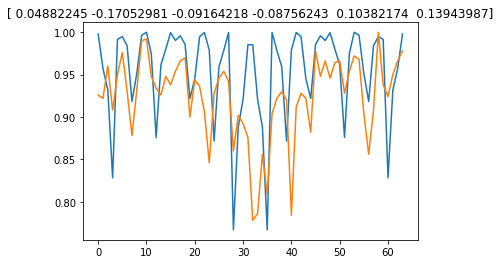

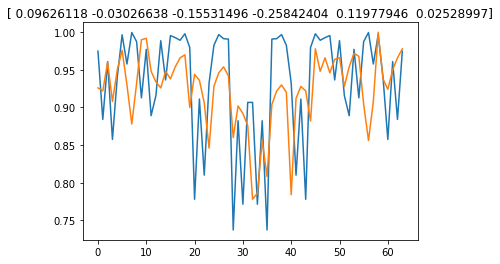

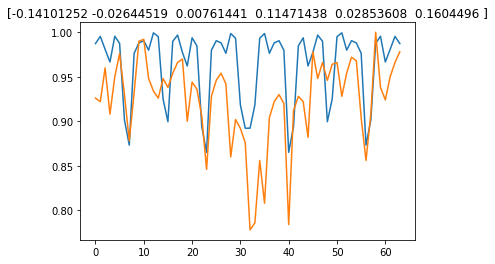

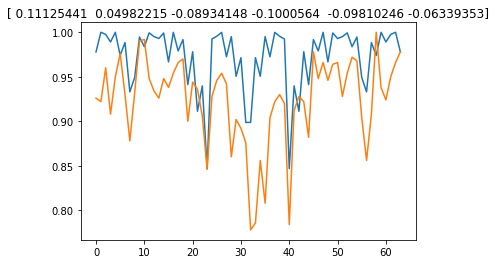

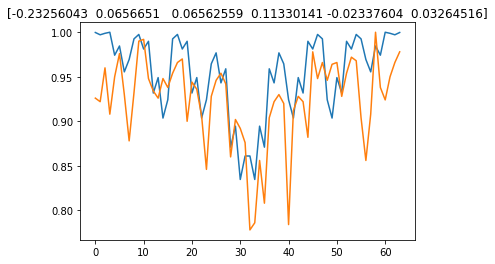

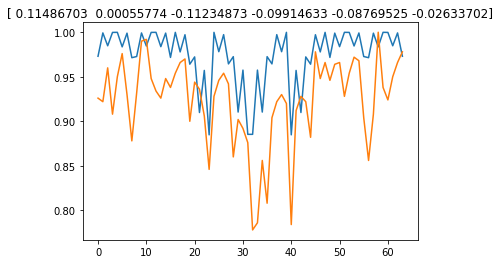

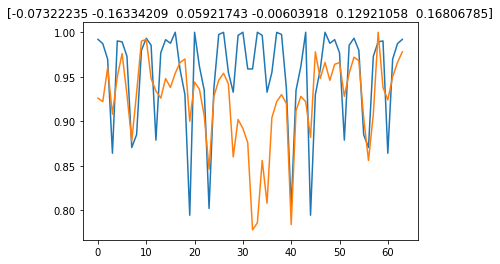

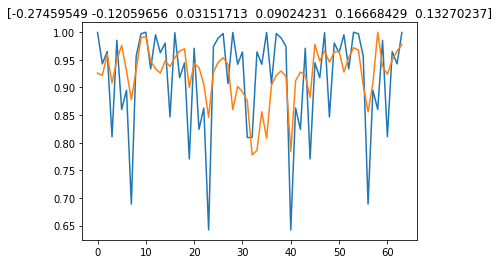

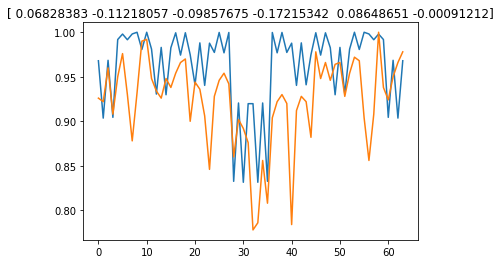

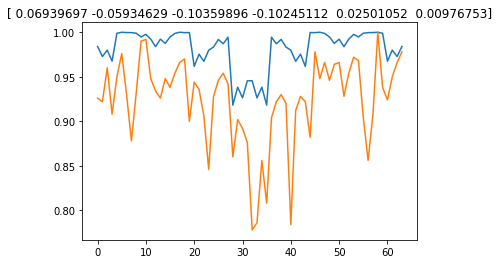

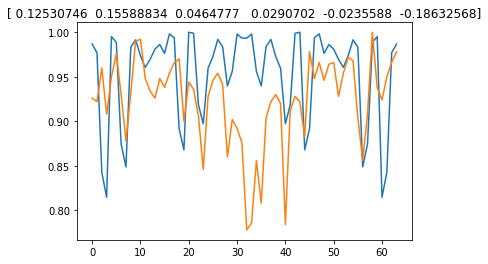

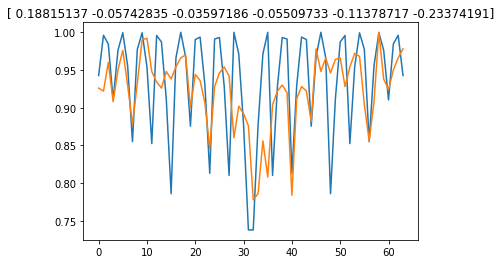

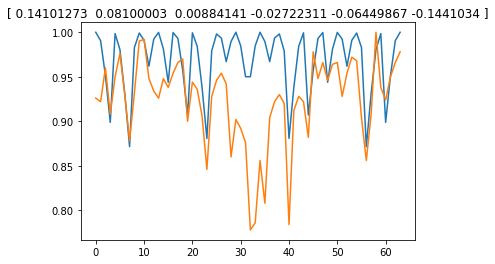

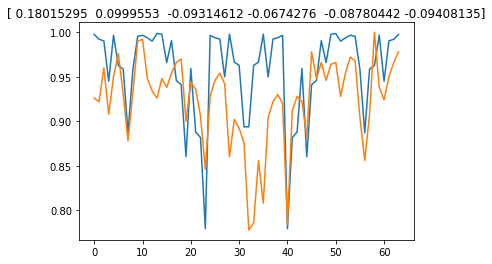

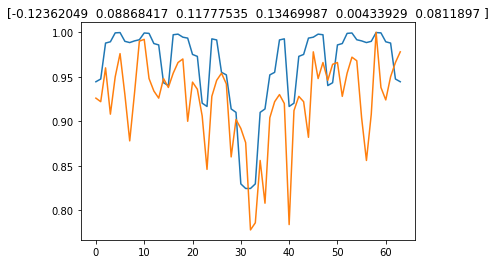

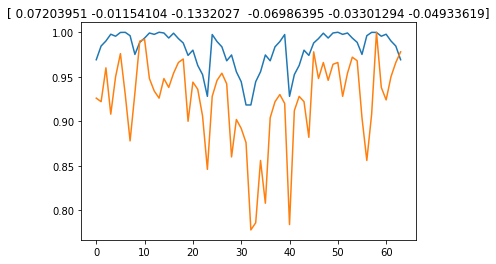

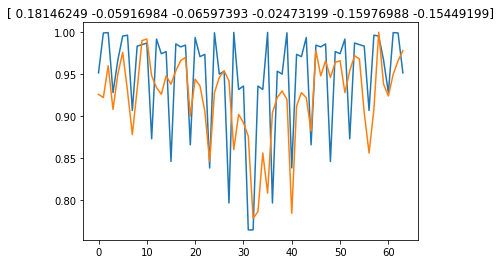

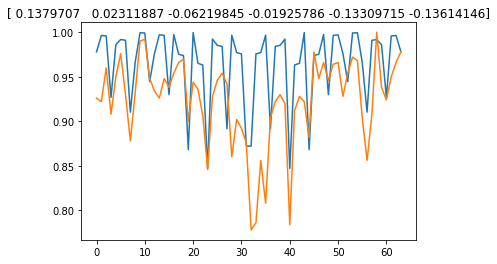

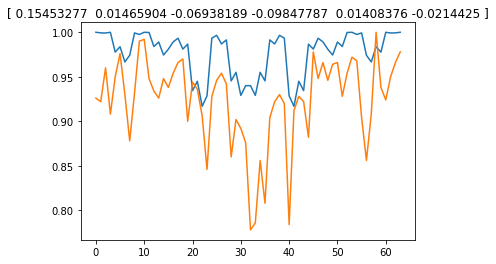

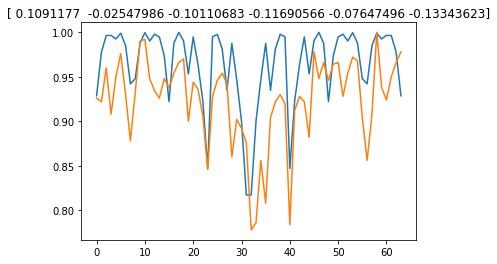

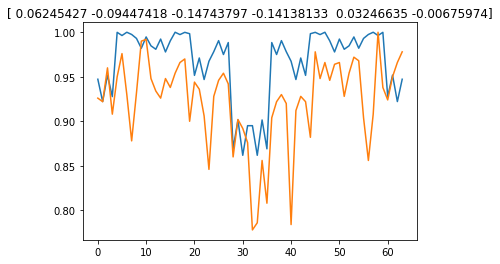

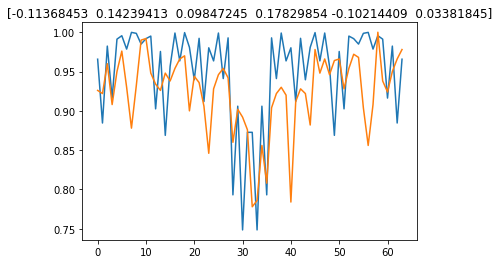

In [149]:
runs = 2
err = [0, 0, 0]
exp_list = [3, 7, 19, 22, 23, 28, 29, 30, 31]
matching_no = 5
predicted_results = []

start = time.time()
sim_runs = 1000

for i in range(sim_runs):
    # Randomly generated error distribution for 2-qubit gates
    err_arr = 0.3 * error_dist(N-1)
    
    final_states, ideal_states = run_parallel_circ(runs, err, err_arr=err_arr)
    results = fid_dist(final_states, ideal_states, title=f"Error array = {err_arr}", plot=False, analyze=False)
    
    sim_list = [x for x in argsort(results)[:18] if x < 32]
    sim_list.sort()
    
    matching_list = [x for x in sim_list if x in exp_list]
    if len(matching_list) > matching_no:
        predicted_results.append({"err_arr": err_arr, "results": results, 'lowest_fidelities': sim_list})

len(predicted_results)

# print(f"Best predicted error array = {predicted_results['err_arr']}")
# print(f"Lowest fidelities = {predicted_results['lowest_fidelities']}")
# print(f"Compare with experiment = {exp_list}")
# print(f"No. of matching lowest fidelities = {matching_no} out of {len(exp_list)}")
# print(f"Time elapsed for {sim_runs} runs = {time.time() - start} s")

for result in predicted_results:
    plt.figure()
    plt.title(f"{result['err_arr']}")
    plt.plot(result['results'])
    plt.plot(array(all_exp_fids) + 0.1)
    plt.show()

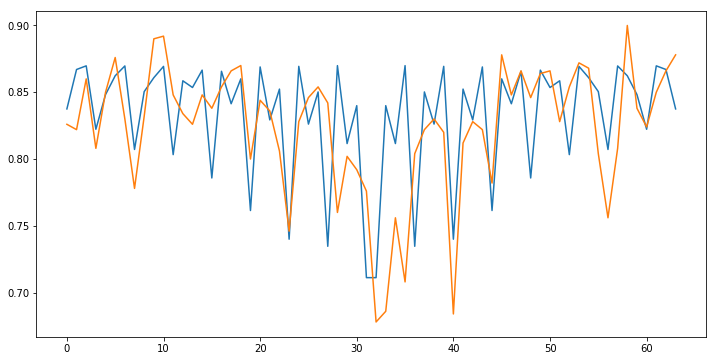

In [132]:
runs = 2
err = [0,0,0]
err_arr = 1.6 * array([-0.09098919,  0.01631104,  0.04595843,  0.01318954,  0.09377026,  0.06595771]) # Best so far
adjusted_arr = err_arr - average(err_arr)

offset = 0.13

final_states, ideal_states = run_parallel_circ(runs, err, err_arr=err_arr)
results = array(fid_dist(final_states, ideal_states, title=f"Error array = {err_arr}", plot=False, analyze=False)) \
             - offset

all_exp_fids = array([0.826, 0.822, 0.86 , 0.808, 0.85 , 0.876, 0.83 , 0.778, 0.832,
       0.89 , 0.892, 0.848, 0.834, 0.826, 0.848, 0.838, 0.854, 0.866,
       0.87 , 0.8  , 0.844, 0.836, 0.806, 0.746, 0.828, 0.846, 0.854,
       0.842, 0.76 , 0.802, 0.792, 0.776, 0.678, 0.686, 0.756, 0.708,
       0.804, 0.822, 0.83 , 0.82 , 0.684, 0.812, 0.828, 0.822, 0.782,
       0.878, 0.848, 0.866, 0.846, 0.864, 0.866, 0.828, 0.854, 0.872,
       0.868, 0.804, 0.756, 0.808, 0.9  , 0.838, 0.824, 0.85 , 0.866,
       0.878])

plt.figure(1, figsize=(12,6))
plt.plot(results)
plt.plot(all_exp_fids)
plt.show()

0.038452744000000004


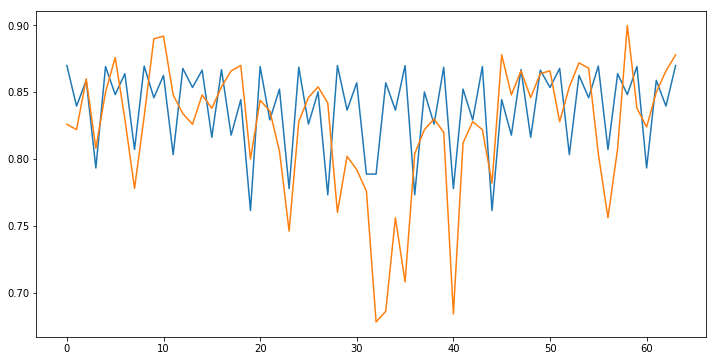

In [105]:
adjusted_arr = err_arr - average(err_arr)

final_states, ideal_states = run_parallel_circ(runs, err, err_arr=adjusted_arr)
results = array(fid_dist(final_states, ideal_states, title=f"Error array = {err_arr}", plot=False, analyze=False)) \
             - offset

plt.figure(1, figsize=(12,6))
plt.plot(results)
plt.plot(all_exp_fids)
plt.show()


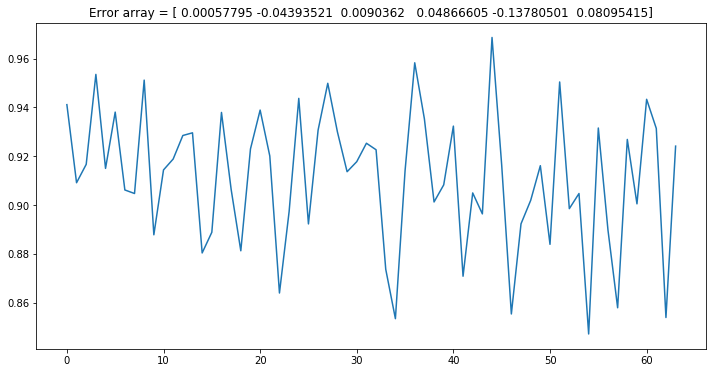

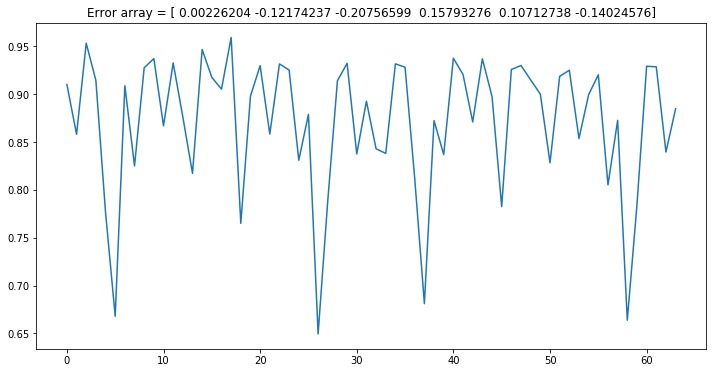

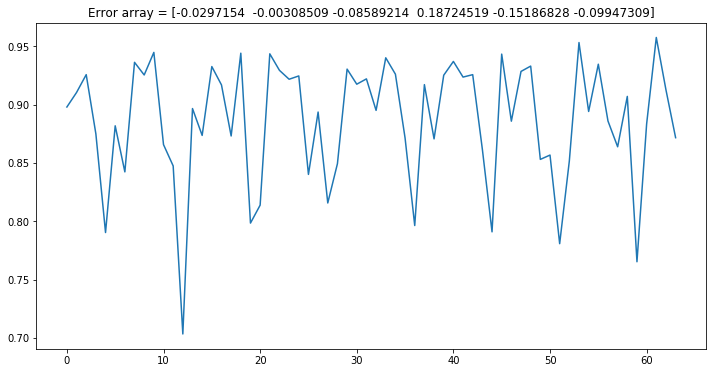

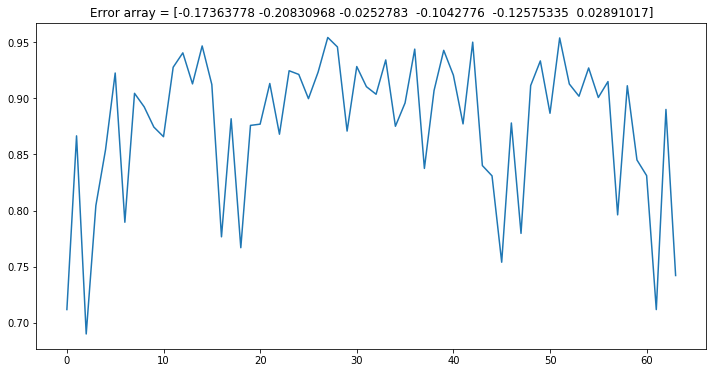

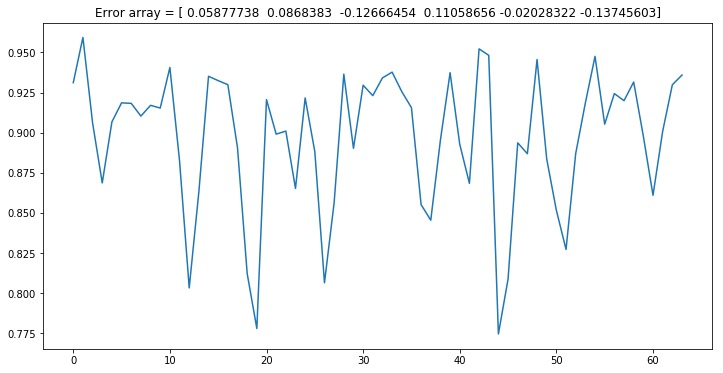

In [49]:
# Random errors average out when runs >> 1
runs = 2
err = [0.2, 0.2, 0]

for i in range(5):
    err_arr = 0.3 * error_dist(N-1)
#     print(f"Error array = {err_arr}")
    # err_arr = array([-0.1, 0.01, 0.09, -0.05, -0.03, 0.08])
    final_states, ideal_states = run_parallel_circ(runs, err, err_arr=err_arr)
    full_fid_plot(final_states, ideal_states, title=f"Error array = {err_arr}", plot=True, analyze=False)

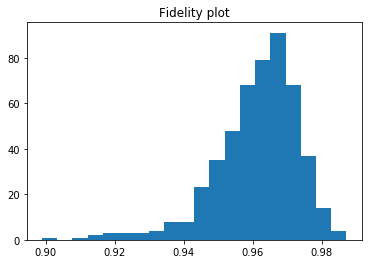

Average fidelity = 0.9612811176493135
10-th percentile fidelity = 0.947093200211109
90-th percentile fidelity = 0.974195822738627


In [18]:
len(final_states[2 * runs: (2 + 1) * runs])
fidelities = find_fidelities(final_states[2 * runs: (2 + 1) * runs], ideal_states[2 * 2])
plot_fidelities(fidelities)

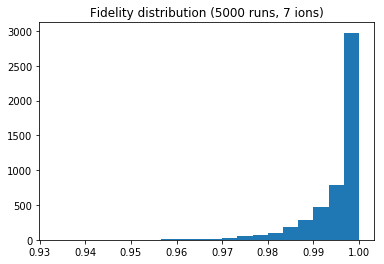

Average fidelity = 0.995145628856136
10-th percentile fidelity = 0.9868956071789965
90-th percentile fidelity = 0.9999107038022188
Time elapsed = 0.5443570613861084 s


In [21]:
# Stabilizer measurement with bare ancilla
N = 7

# A set of single-qubit pi/2 gates applied to the first N-1 qubits
bit_str = [0, 0, 1, 0, 0, 1]

circ = stab_meas_circ(bit_str)
ideal_state = circ.compute()[0]

circ.runs = 5000
circ.errors = [0, 0, 0.1]

start = time.time()

final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, title=title)

print(f"Time elapsed = {time.time() - start} s")

In [22]:
circ.native_gates

[[['S_phi'], [0], 1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [1], 1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [2], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [3], 1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [4], 1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [5], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi', 'S_phi'], [0, 6], 1.5707963267948966, [0, 0]],
 [['S_phi', 'S_phi'], [2, 6], -1.5707963267948966, [0, 0]],
 [['S_phi', 'S_phi'], [1, 6], 1.5707963267948966, [0, 0]],
 [['S_phi', 'S_phi'], [3, 6], -1.5707963267948966, [0, 0]],
 [['S_phi', 'S_phi'], [5, 6], 1.5707963267948966, [0, 0]],
 [['S_phi', 'S_phi'], [4, 6], -1.5707963267948966, [0, 0]],
 [['S_phi'], [0], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [1], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [2], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [3], -1.5707963267948966, [1.5707963267948966]],
 [['S_phi'], [4], -1.570796

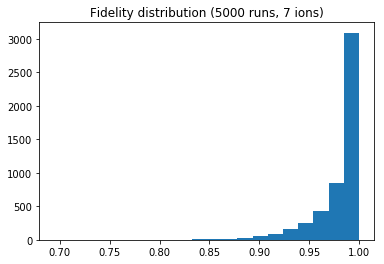

Average fidelity = 0.980754205242084
10-th percentile fidelity = 0.9478349775338172
90-th percentile fidelity = 0.999703050583399
Time elapsed = 0.5093681812286377 s


In [6]:
circ.errors = [0, 0, 0.2]

start = time.time()

final_states = circ.compute()

fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, title=title)

print(f"Time elapsed = {time.time() - start} s")

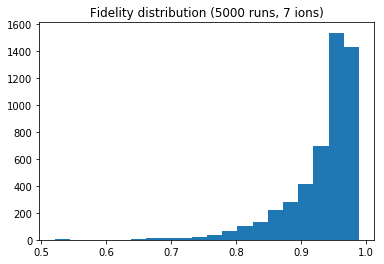

Average fidelity = 0.9319210326491552
10-th percentile fidelity = 0.8575148505364836
90-th percentile fidelity = 0.9755019054291709
Time elapsed = 0.5014309883117676 s


In [7]:
circ.errors = [0.1, 0.1, 0.3]

start = time.time()

final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, title=title)

print(f"Time elapsed = {time.time() - start} s")

In [8]:
bit_str_to_int(bit_str = [0, 0, 1, 0, 0, 1])

9

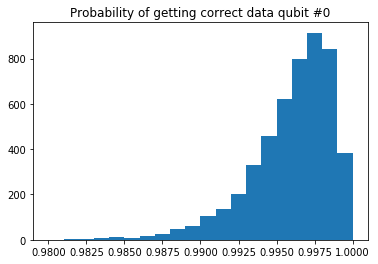

Average probability = 0.9959593433613474
10-th percentile probability = 0.9922684573500776
90-th percentile probability = 0.9988440729589066


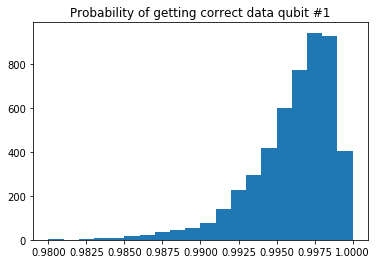

Average probability = 0.9960539450514847
10-th percentile probability = 0.9923808052586751
90-th percentile probability = 0.9988836260886261


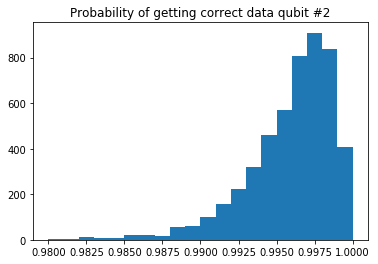

Average probability = 0.9959242516015342
10-th percentile probability = 0.9921924612358909
90-th percentile probability = 0.9988704195289456


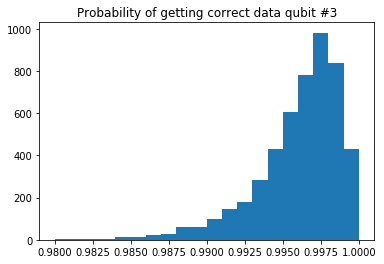

Average probability = 0.9960180429155836
10-th percentile probability = 0.9922583299484513
90-th percentile probability = 0.9989147321938789


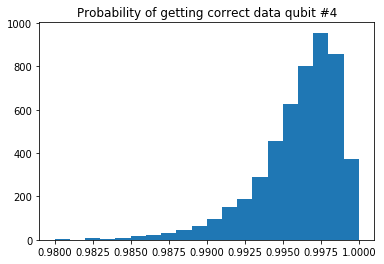

Average probability = 0.995965328968129
10-th percentile probability = 0.9922612468982055
90-th percentile probability = 0.9988279816389505


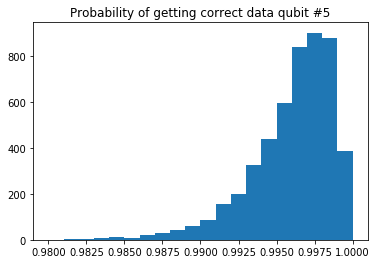

Average probability = 0.995979009397356
10-th percentile probability = 0.9923458860681761
90-th percentile probability = 0.9988437791171713


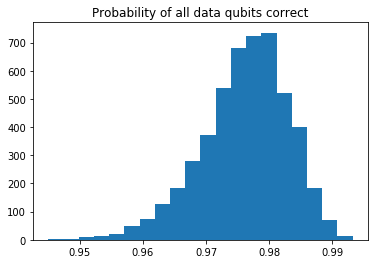

Average probability = 0.9761408264543161
10-th percentile probability = 0.9668968702212747
90-th percentile probability = 0.9844357180515249


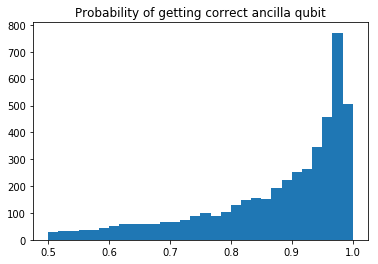

Average probability = 0.8395503680768048
10-th percentile probability = 0.5900524852642994
90-th percentile probability = 0.9834100435562025


In [9]:
bit_str = [0, 0, 1, 0, 0, 1]
circ = stab_meas_circ(bit_str)
circ.errors = [0.1, 0.1, 0.6]
circ.runs = 5000
final_states = circ.compute()

# -- Probability of measuring data qubits correctly (individual) --
for i in range(N-1):
    measured_qubits = [i]
    sub_state = zero_state(1) * 0
    sub_state[bit_str[i]] = 1
    probs = find_prob(measured_qubits, sub_state, final_states)

    title = f"Probability of getting correct data qubit #{i}"
    plot_prob(probs, range=(0.98, 1), title=title)

# -- Probability of getting all data qubits correct --
measured_qubits = list(range(N - 1))
sub_state = zero_state(N - 1) * 0
sub_state[bit_str_to_int(bit_str)] = 1

probs = find_prob(measured_qubits, sub_state, final_states)

title = f"Probability of all data qubits correct"
plot_prob(probs, title=title)

# -- Getting the correct ancilla --
measured_qubits = [6]
sub_state = zero_state(1) * 0
sub_state[0] = 1

probs = find_prob(measured_qubits, sub_state, final_states)

title = f"Probability of getting correct ancilla qubit"
plot_prob(probs, range=(0.5, 1), bins=30, title=title)



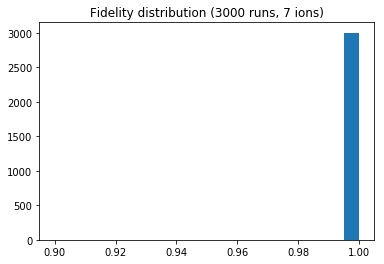

Average fidelity = 0.9999999999999999
10-th percentile fidelity = 0.9999999999999996
90-th percentile fidelity = 0.9999999999999996
Time elapsed = 0.40192103385925293 s


In [10]:
# -- Introduce correlations -- 

circ.runs = 3000

# Assume all gates over-rotate by 20% 
err = 0.2

# Alter "ideal gates" accordingly
for i in range(N - 1):
    circ.ideal_gates[i + N - 1][2] *= 1 + err

# No randomness
circ.errors = [0, 0, 0]

start = time.time()

final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, bins=20, range=(0.9, 1), title=title)

print(f"Time elapsed = {time.time() - start} s")

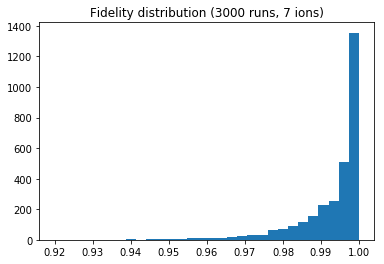

Average fidelity = 0.9932154473049841
10-th percentile fidelity = 0.981827968323617
90-th percentile fidelity = 0.9999022465104777
Time elapsed = 0.40192294120788574 s


In [11]:
# Introduce random over-rotations for 2-qubit gates
circ.errors = [0, 0, 0.1]

start = time.time()

final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, bins=30, range=(0.92, 1), title=title)

print(f"Time elapsed = {time.time() - start} s")

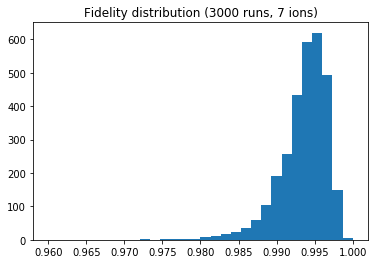

Average fidelity = 0.9935770646250277
10-th percentile fidelity = 0.9895910207366865
90-th percentile fidelity = 0.9968082439276873
Time elapsed = 0.38929200172424316 s


In [12]:
# Random phase error for single-qubit gates as well
circ.errors = [0.00, 0.05, 0.05]

start = time.time()

final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

# Plot fidelity histogram
title = f'Fidelity distribution ({circ.runs} runs, {N} ions)'
plot_fidelities(fidelities, bins=30, range=(0.96, 1), title=title)

print(f"Time elapsed = {time.time() - start} s")

Number of data = 64
Average fidelity = 0.16904173727389793
Max fidelity minus Min fidelity = 0.13384319350183932
Variance = 0.000701684202461106
Number of data = 64
Average fidelity = 0.16890300466084213
Max fidelity minus Min fidelity = 0.03906674109760322
Variance = 5.883724229314603e-05


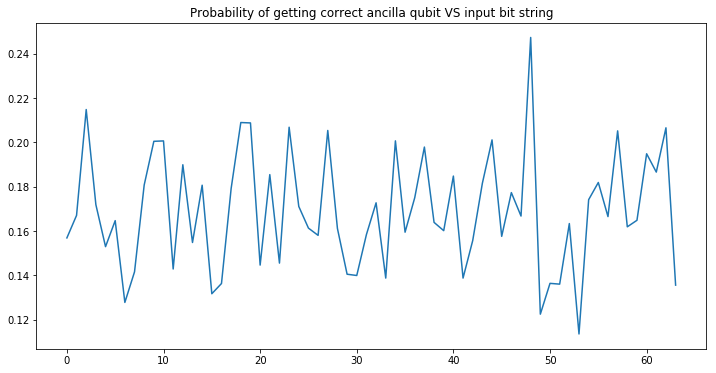

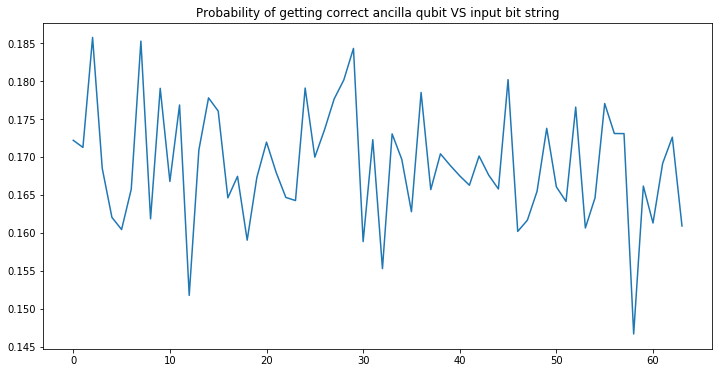

In [38]:
# Time-dependent errors only, averaged over 50 runs
# Average fidelity ~ 0.833
errors = [0.1, 0.1, 0.62]
rep_fid_plot(50, errors)
rep_fid_plot(500, errors)
# rep_fid_plot(5000, errors)

Number of data = 64
Average fidelity = 0.9598363559586403
Max fidelity minus Min fidelity = 0.2136449341538118
Variance = 0.002550546019337508
Number of data = 64
Average fidelity = 0.9610700286015423
Max fidelity minus Min fidelity = 0.43043997794544553
Variance = 0.004787093886645338
Number of data = 64
Average fidelity = 0.9509980375480364
Max fidelity minus Min fidelity = 0.28080586569476884
Variance = 0.003374112959467941
Number of data = 64
Average fidelity = 0.9592661452730338
Max fidelity minus Min fidelity = 0.23645002594899633
Variance = 0.0025656360234651635
Number of data = 64
Average fidelity = 0.956157350541047
Max fidelity minus Min fidelity = 0.22014252384757238
Variance = 0.002369803681204997


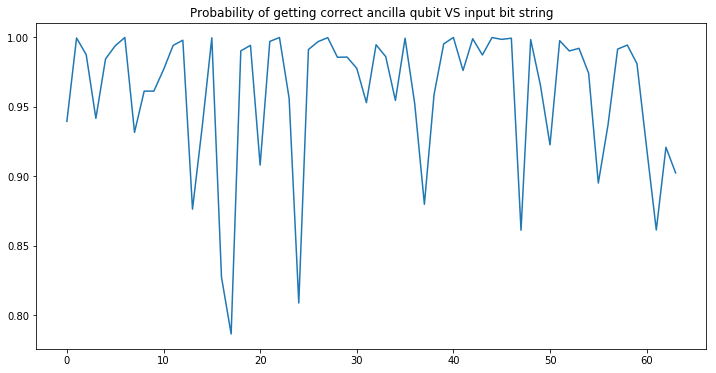

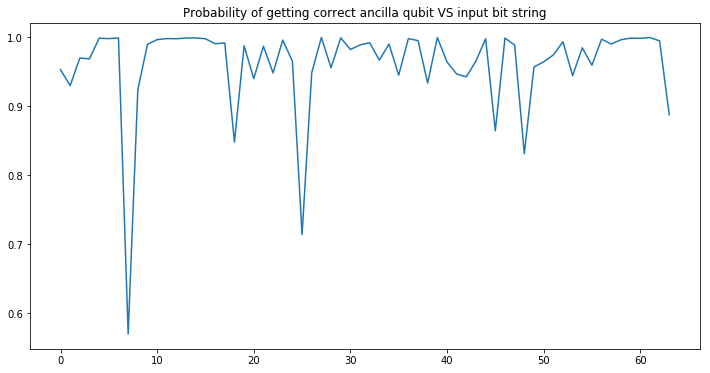

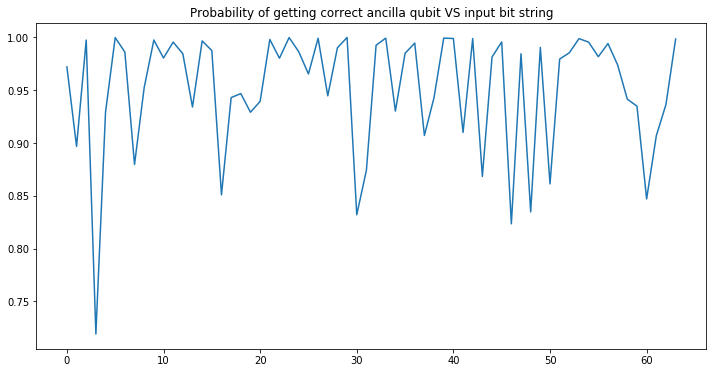

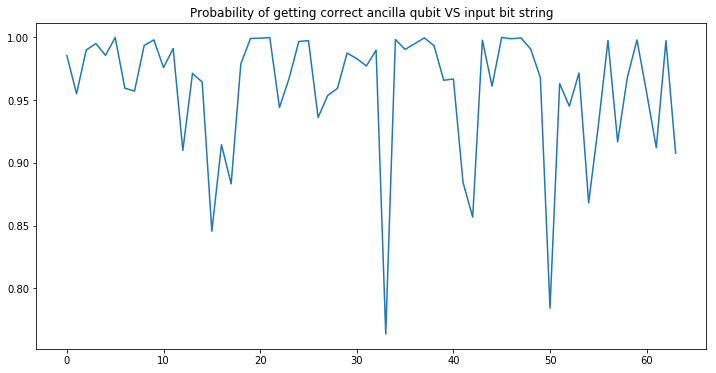

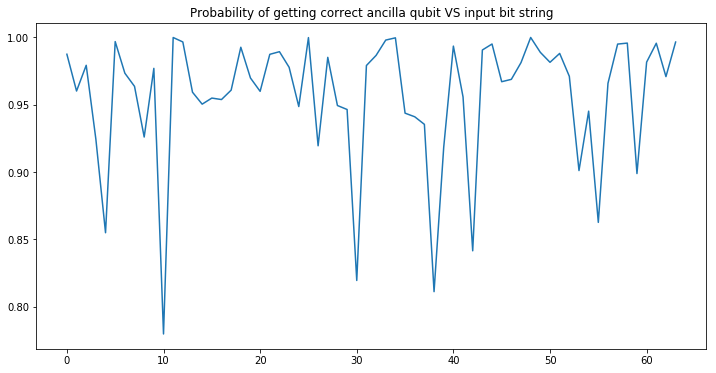

In [94]:
# A mix of time-independent (0.3) and time-dependent (0.6) errors
# To match both average and variance of experimental data
    runs = 500
    errors = [0, 0, 0]
    rep_fid_plot(runs, errors, rand_err=0.3)

In [163]:
# Time-independent errors only
# Comparison with experimental results

runs = 2
errors = [0., 0., 0]
err_arr_0 = - array([0.1, 0.05, 0.01, 0.01, 0.05, 0.1]) * 0 - 0.1

mins = [3, 7, 19, 23, 28]
mins += [63 - x for x in mins]

fids_arr = []
gate_data = []
for i in range(500):
    err_arr = err_arr_0 + 0.0 * i

    gate_angles, fidelities = rep_fid_plot(runs, errors, err_arr=err_arr, rand_err=0.1, plot=False)
    
    fids_arr.append(fidelities)
    gate_data.append(gate_angles)

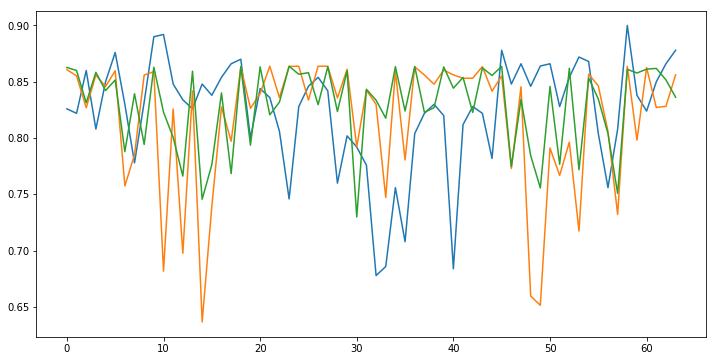

In [180]:
from numpy import linalg as LA

all_exp_fids = array([0.826, 0.822, 0.86 , 0.808, 0.85 , 0.876, 0.83 , 0.778, 0.832,
       0.89 , 0.892, 0.848, 0.834, 0.826, 0.848, 0.838, 0.854, 0.866,
       0.87 , 0.8  , 0.844, 0.836, 0.806, 0.746, 0.828, 0.846, 0.854,
       0.842, 0.76 , 0.802, 0.792, 0.776, 0.678, 0.686, 0.756, 0.708,
       0.804, 0.822, 0.83 , 0.82 , 0.684, 0.812, 0.828, 0.822, 0.782,
       0.878, 0.848, 0.866, 0.846, 0.864, 0.866, 0.828, 0.854, 0.872,
       0.868, 0.804, 0.756, 0.808, 0.9  , 0.838, 0.824, 0.85 , 0.866,
       0.878])
exp_fids = array([0.808, 0.778, 0.8, 0.746, 0.76, 0.824, 0.756, 0.782, 0.684, 0.708])

# Adjust to match average
fid_adjust = average(fids_arr[8]) - average(all_exp_fids)
adjusted_fids = array(fids_arr) - fid_adjust

dev1 = []
dev2 = []

for i in range(len(adjusted_fids)):
    dev1.append(LA.norm([adjusted_fids[i][x] for x in mins] - exp_fids))
    dev2.append(LA.norm(adjusted_fids[i] - all_exp_fids))

plt.figure(1, figsize=(12,6))
plt.plot(all_exp_fids)
plt.plot(adjusted_fids[argmin(dev1)])
plt.plot(adjusted_fids[argmin(dev2)])

# plt.figure(2)
# plt.plot(all_exp_fids)
# plt.plot(fids_arr[argmin(dev)] - fid_adjust)
# plt.show()

In [73]:
# A mix of time-independent (0.3) and time-dependent (0.6) errors
# To match both average and variance of experimental data
for i in range(5):
    runs = 500
    errors = [0.1, 0.1, 0.62]
    rep_fid_plot(runs, errors, corr_err=0.3)

TypeError: rep_fid_plot() got an unexpected keyword argument 'corr_err'

Number of data = 64
Average fidelity = 0.8340383484471559
Max fidelity minus Min fidelity = 0.03693559969303717
Variance = 6.418711526123964e-05


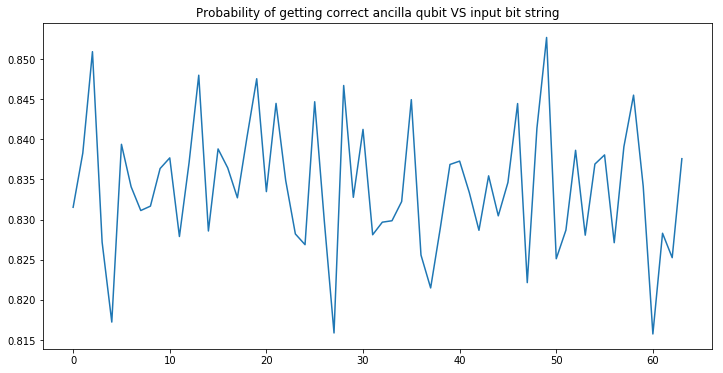

In [17]:
# A mix of time-independent (0.3) and time-dependent (0.6) errors
# To match both average and variance of experimental data
runs = 500
errors = [0.1, 0.1, 0.62]
rep_fid_plot(runs, errors)

In [ ]:
# Parity plots?
# Simulate state prep errors: additional rotation?
# Simulate measurement errors: probabilistic?

# Errors correlated --> independent measurement errors don't explain high parity correlation

# Y-covariance? Fidelity below average more extreme than above average --> coherent errors dominate
# How to take into account incoherent type errors (e.g. incoherent type motion)?


3.605551275463989